# Reliability anaysis


## Packages and Helpers

In [4]:
# packages
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from utils import load_dataframes
from scipy.stats import pearsonr
import random
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
import pingouin as pg
import seaborn as sns

## Read Processed Data

In [5]:
# load overall df
all_data = pd.read_csv("processed_data/items_per_LLM.csv")

## Normalize Scales

In [6]:
# def normalize_per_scale(data):
#     scales_to_normalize = ["AUDIT scale", "FTND scale", "GABS scale", "PG scale", "PRI scale"]
#     grouped = data.groupby(["experiment"])
#     data["normalized_score"] = grouped["score"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
#     data["normalized_score_top_n"] = grouped["score_top_n"].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
#     return data

# all_data = normalize_per_scale(all_data)
# all_data


In [7]:
# task_names = all_data['experiment'].unique()
# model_names = all_data["model"].unique()
# for model_name in model_names:
#     #for task_name in task_names:
#     sub_df = all_data[
#         (all_data['model'] == model_name) &
#         (all_data['experiment'] == "DFD task")
#     ]
#     print(sub_df)

## Chronbach's Alpha

In [8]:
# function:
def compute_cronbach_alpha(score = "score"):
    results = []

    # loop through experiments
    for exp, exp_data in all_data.groupby("experiment"):
        
        # check whether this experiment has subcategories
        if exp_data["category"].notna().any() and exp != "SOEP scale":
            # compute alpha per category (domain)
            for domain, domain_data in exp_data.groupby("category"):
                df_wide = domain_data.pivot_table(
                    index="model", columns="item", values=score
                )
                #print(df_wide)
                if df_wide.shape[1] > 1:
                    alpha, ci = pg.cronbach_alpha(df_wide)
                else:
                    alpha, ci = None, (None, None)
                
                results.append({
                    "experiment": exp,
                    "domain": domain,
                    "alpha": alpha,
                    "alpha_CI": ci
                })
        else:
            # compute alpha for the whole experiment
            df_wide = exp_data.pivot_table(
                index="model", columns="item", values=score
            )
            #print(exp, df_wide.std().describe())
            if df_wide.shape[1] > 1:
                alpha, ci = pg.cronbach_alpha(df_wide)
            else:
                alpha, ci = None, (None, None)
            
            results.append({
                "experiment": exp,
                "domain": "total",  # no subdomain
                "alpha": alpha,
                "alpha_CI": ci
            })

    # convert to DataFrame
    return(pd.DataFrame(results))



In [9]:
# ---- Cronbach's alpha per domain or directly per scale, depending on whether the scale has subdomains ----
alpha_df = compute_cronbach_alpha()

# ---- Cronbach's alpha per domain or directly per scale, depending on whether the scale has subdomains ----
#alpha_df_normalized = compute_cronbach_alpha(score = "normalized_score")

# ---- Cronbach's alpha per domain or directly per scale, depending on whether the scale has subdomains ----
alpha_top_n_df = compute_cronbach_alpha(score = "score_top_n")

# ---- Cronbach's alpha per domain or directly per scale, depending on whether the scale has subdomains ----
#alpha_top_n_df_normalized = compute_cronbach_alpha(score = "normalized_score_top_n")

# Merge only selected columns
alpha_df = alpha_df.merge(
    alpha_top_n_df,
    on=["experiment", "domain"],
    how="inner",
    suffixes=("_total", "_top_n")
)

# alpha_df_norm = alpha_df_normalized.merge(
#     alpha_top_n_df_normalized,
#     on=["experiment", "domain"],
#     how="inner",
#     suffixes=("_total", "_top_n")
# )

# alpha_df = alpha_df.merge(
#     alpha_df_norm,
#     on=["experiment", "domain"],
#     how="inner",
#     suffixes=("_orig", "_normalized")
# )

display(alpha_df)

,experiment,domain,alpha_total,alpha_CI_total,alpha_top_n,alpha_CI_top_n
0,AUDIT scale,total,0.734676,"[0.605, 0.835]",0.450363,"[0.181, 0.659]"
1,BARRAT scale,BISa,0.830566,"[0.745, 0.896]",0.752462,"[0.627, 0.847]"
2,BARRAT scale,BISm,0.830683,"[0.748, 0.895]",0.807216,"[0.713, 0.88]"
3,BARRAT scale,BISn,0.761134,"[0.644, 0.852]",0.663099,"[0.498, 0.791]"
4,BART task,total,0.984716,"[0.977, 0.991]",0.984364,"[0.977, 0.99]"
5,CARE scale,CAREa,0.856412,"[0.785, 0.911]",0.892074,"[0.838, 0.933]"
6,CARE scale,CAREs,0.651253,"[0.468, 0.787]",0.688656,"[0.525, 0.81]"
7,CARE scale,CAREw,0.961134,"[0.939, 0.977]",0.938256,"[0.903, 0.963]"
8,CCT task,total,0.984565,"[0.977, 0.991]",0.978183,"[0.967, 0.987]"
9,DAST scale,total,0.768345,"[0.659, 0.855]",0.830579,"[0.751, 0.894]"


In [10]:
df_wide = all_data[all_data["experiment"] == "SSSV scale"].pivot_table(index='model', columns='item', values='score')

# Compute correlation between models
correlations = df_wide.corr()
correlations

item,1,10,11,12,13,14,15,16,17,18,...,37,38,39,4,40,5,6,7,8,9
item,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.439478,0.318267,0.347741,0.362829,0.354461,0.399569,0.388234,0.360987,0.382929,...,0.237810,0.262865,0.309494,0.405364,0.160062,0.382824,0.314669,0.358463,0.342325,0.461295
10,0.439478,1.000000,0.898186,0.853564,0.879618,0.760255,0.791943,0.784391,0.785396,0.801917,...,0.759073,0.776037,0.742454,0.794849,0.747631,0.846534,0.640700,0.869368,0.887547,0.791960
11,0.318267,0.898186,1.000000,0.936018,0.915164,0.818090,0.799309,0.808251,0.779816,0.843631,...,0.831988,0.843309,0.807113,0.804825,0.823005,0.855859,0.635323,0.918935,0.906649,0.748025
12,0.347741,0.853564,0.936018,1.000000,0.932862,0.809991,0.796560,0.827584,0.822668,0.850113,...,0.788125,0.803162,0.813523,0.831989,0.728204,0.890867,0.641771,0.897522,0.895607,0.808869
13,0.362829,0.879618,0.915164,0.932862,1.000000,0.836941,0.814626,0.881659,0.881895,0.876920,...,0.826594,0.808033,0.804864,0.786509,0.753738,0.868388,0.631477,0.852524,0.899261,0.796922
14,0.354461,0.760255,0.818090,0.809991,0.836941,1.000000,0.922981,0.864413,0.853226,0.882115,...,0.724178,0.726200,0.792875,0.618898,0.731117,0.808473,0.810245,0.849322,0.893626,0.775908
15,0.399569,0.791943,0.799309,0.796560,0.814626,0.922981,1.000000,0.908495,0.877428,0.927076,...,0.739983,0.773045,0.841908,0.631086,0.757815,0.809848,0.786602,0.793443,0.840172,0.769698
16,0.388234,0.784391,0.808251,0.827584,0.881659,0.864413,0.908495,1.000000,0.921573,0.945004,...,0.798446,0.782020,0.820441,0.670593,0.751256,0.801017,0.607856,0.744413,0.799285,0.803790
17,0.360987,0.785396,0.779816,0.822668,0.881895,0.853226,0.877428,0.921573,1.000000,0.894362,...,0.838639,0.839475,0.853664,0.681369,0.772117,0.838283,0.734168,0.718967,0.818954,0.816530


## Split-half Reliability

In [11]:
# ---- Split-half per domain or directly per scale ----
results = []

# loop through experiments
for exp, exp_data in all_data.groupby("experiment"):
    
    # check whether this experiment has subcategories
    if exp_data["category"].notna().any() and exp != "SOEP scale":
        # compute alpha per category (domain)
        for domain, domain_data in exp_data.groupby("category"):
            df_wide = domain_data.pivot_table(
                index="model", columns="item", values="score_top_n"
            )
            if df_wide.shape[1] > 1:
                alpha, ci = pg.cronbach_alpha(df_wide)
            else:
                alpha, ci = None, (None, None)
            
            results.append({
                "experiment": exp,
                "domain": domain,
                "alpha": alpha,
                "alpha_CI": ci
            })
    else:
        # compute alpha for the whole experiment
        df_wide = exp_data.pivot_table(
            index="model", columns="item", values="score_top_n"
        )
        if df_wide.shape[1] > 1:
            alpha, ci = pg.cronbach_alpha(df_wide)
        else:
            alpha, ci = None, (None, None)
        
        results.append({
            "experiment": exp,
            "domain": None,  # no subdomain
            "alpha": alpha,
            "alpha_CI": ci
        })

# convert to DataFrame
alpha_df = pd.DataFrame(results)
display(alpha_df)




,experiment,domain,alpha,alpha_CI
0,AUDIT scale,None,0.450363,"[0.181, 0.659]"
1,BARRAT scale,BISa,0.752462,"[0.627, 0.847]"
2,BARRAT scale,BISm,0.807216,"[0.713, 0.88]"
3,BARRAT scale,BISn,0.663099,"[0.498, 0.791]"
4,BART task,None,0.984364,"[0.977, 0.99]"
5,CARE scale,CAREa,0.892074,"[0.838, 0.933]"
6,CARE scale,CAREs,0.688656,"[0.525, 0.81]"
7,CARE scale,CAREw,0.938256,"[0.903, 0.963]"
8,CCT task,None,0.978183,"[0.967, 0.987]"
9,DAST scale,None,0.830579,"[0.751, 0.894]"


## Visualize Distributions per model

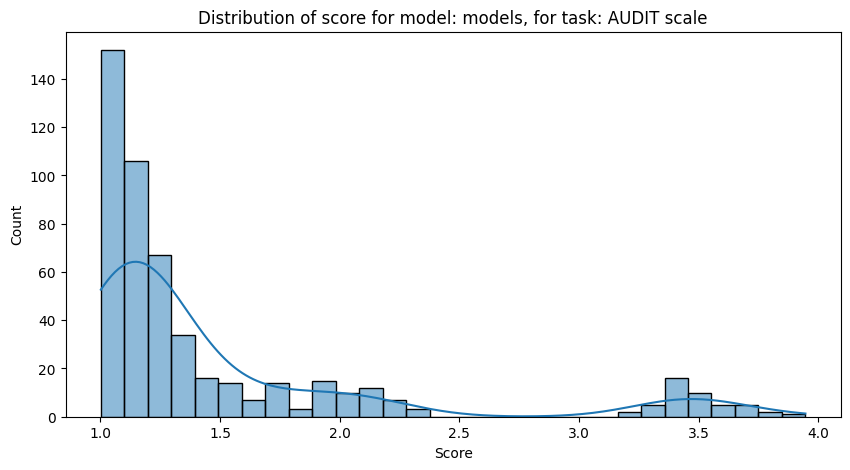

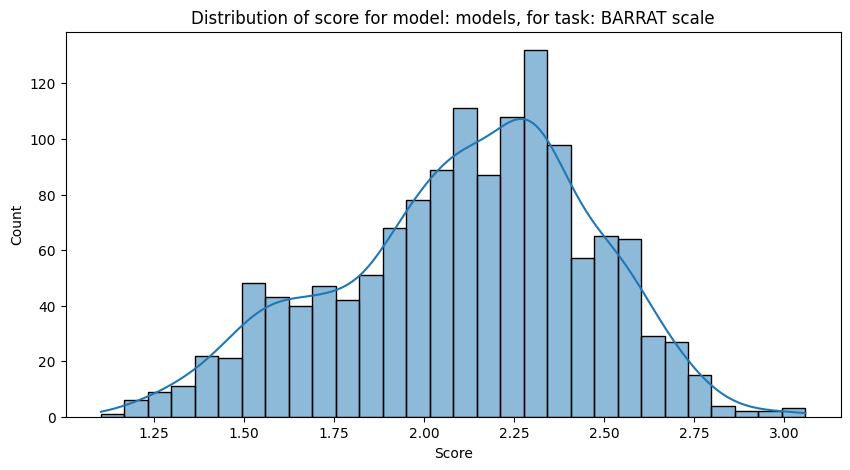

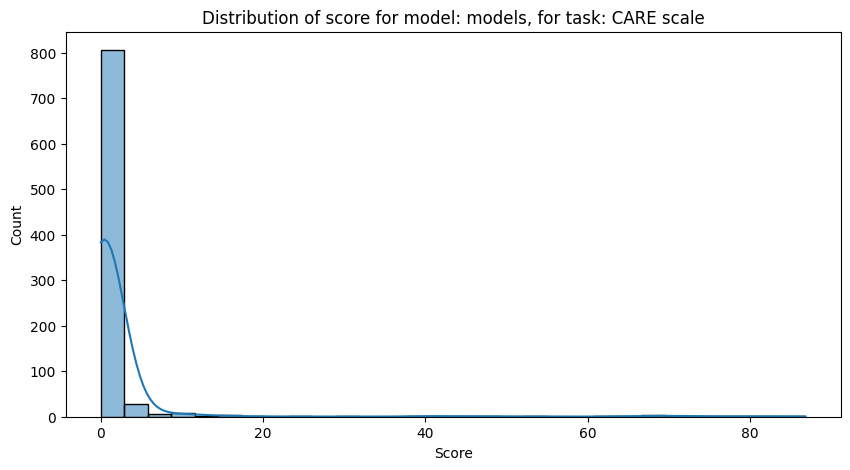

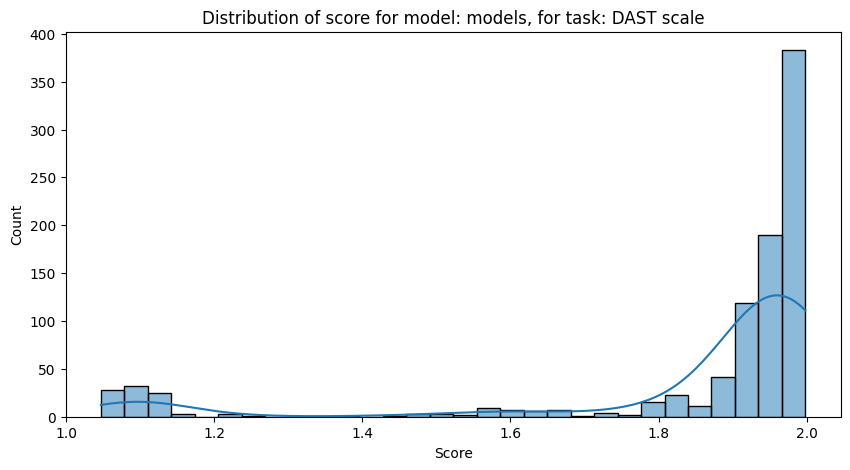

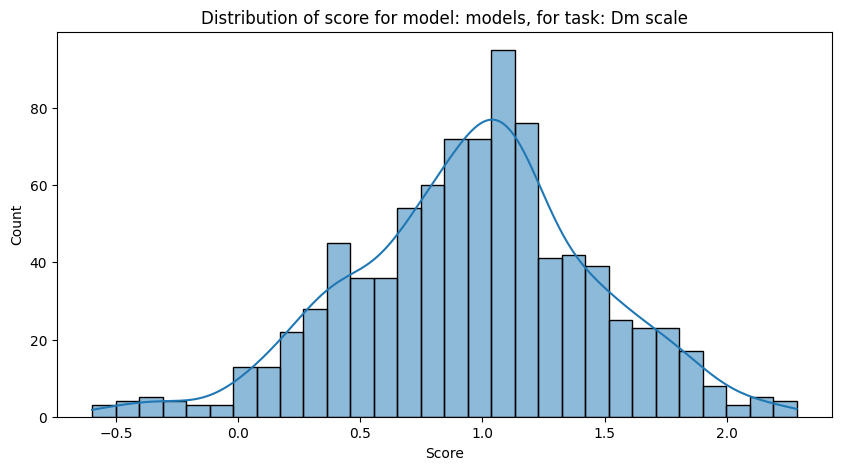

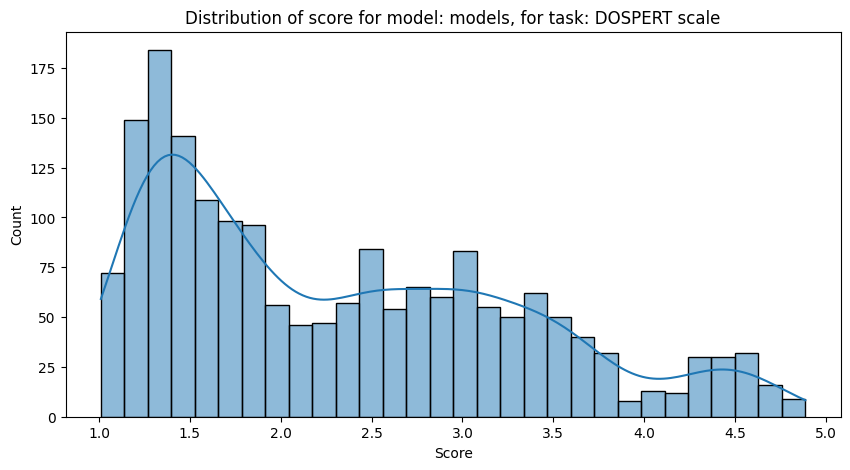

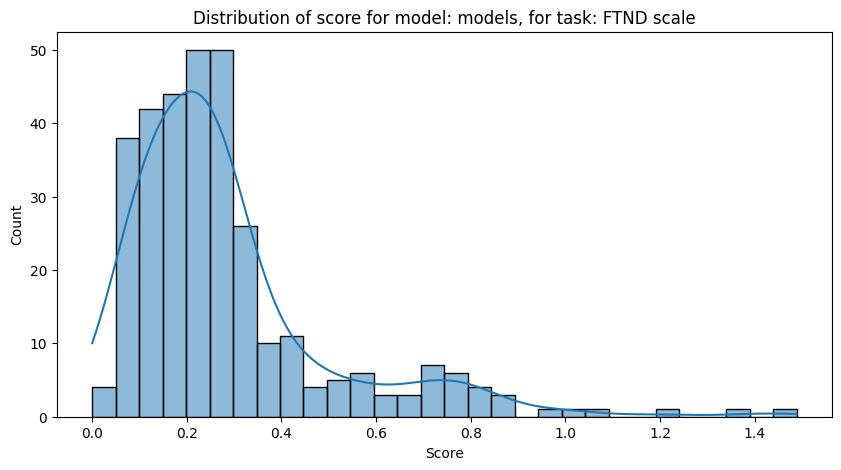

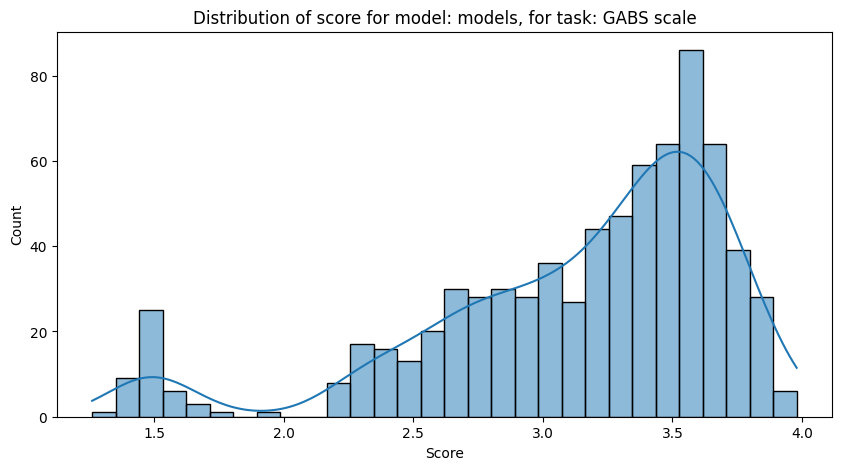

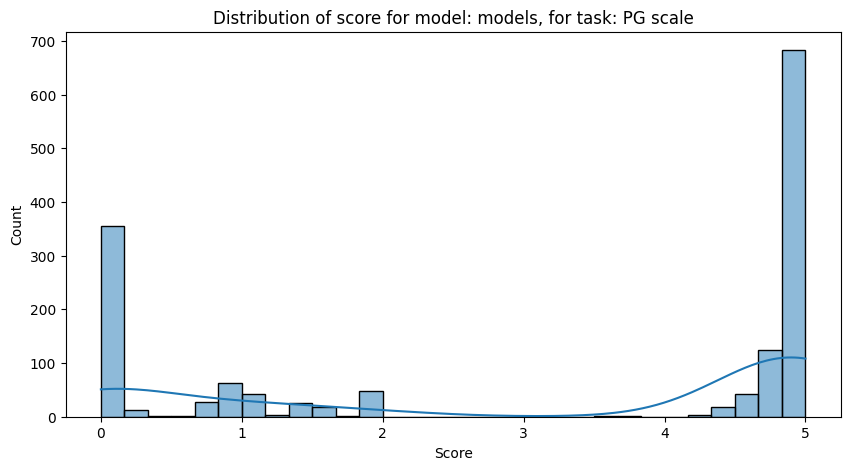

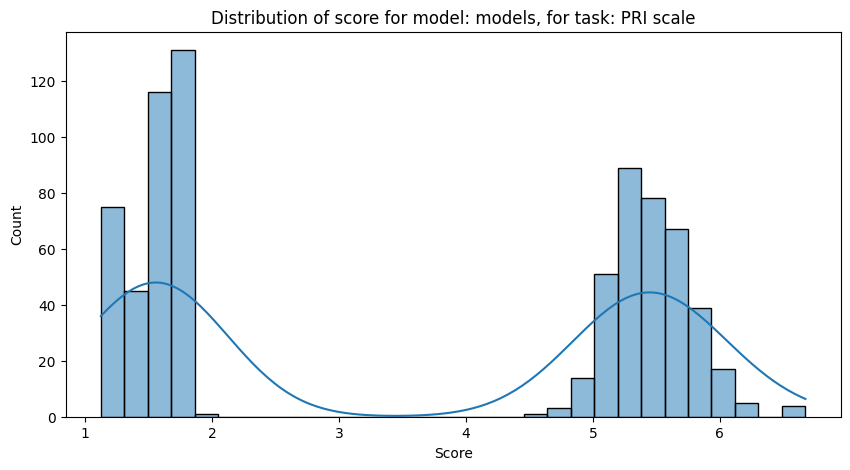

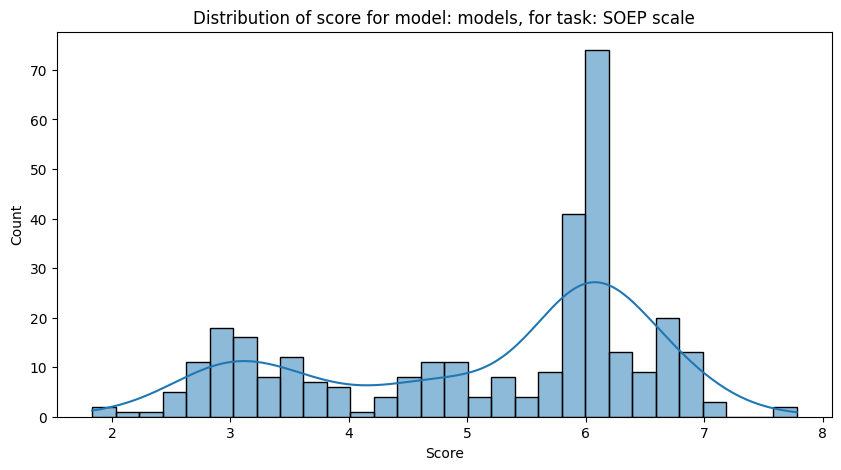

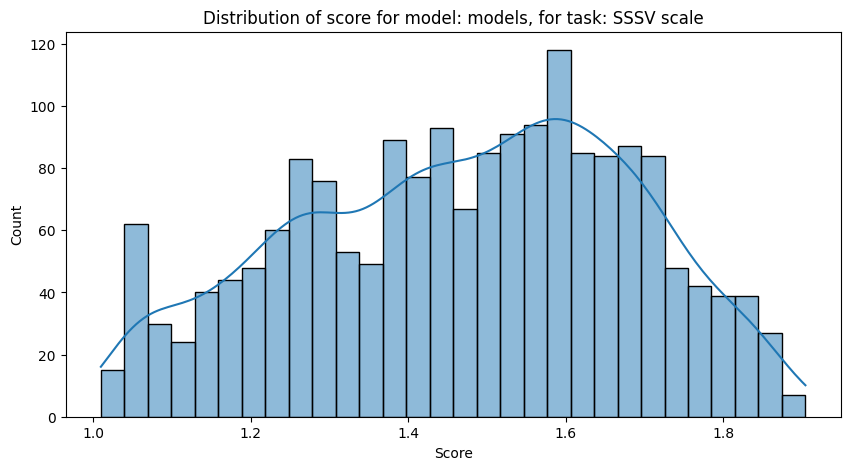

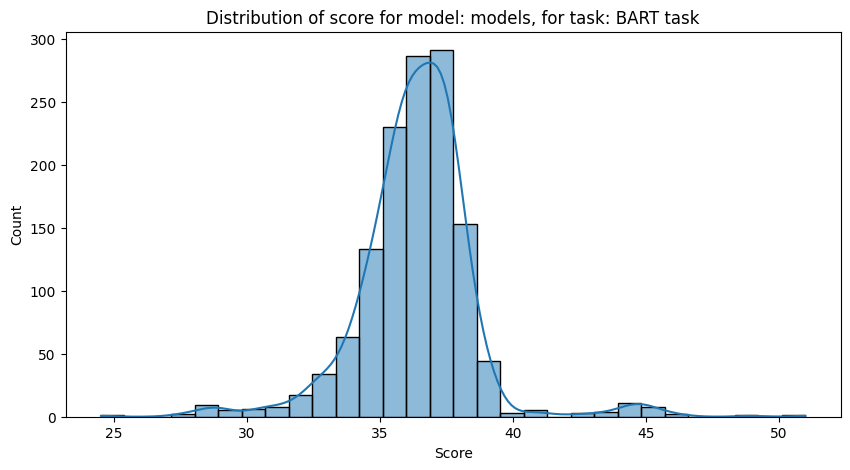

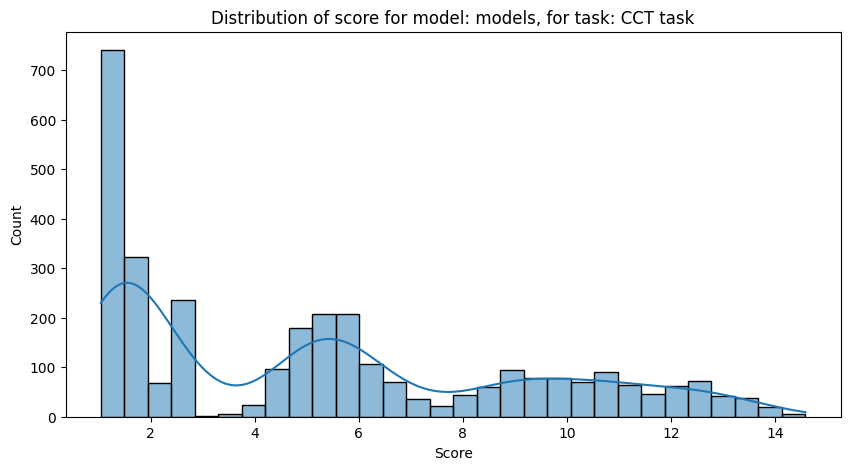

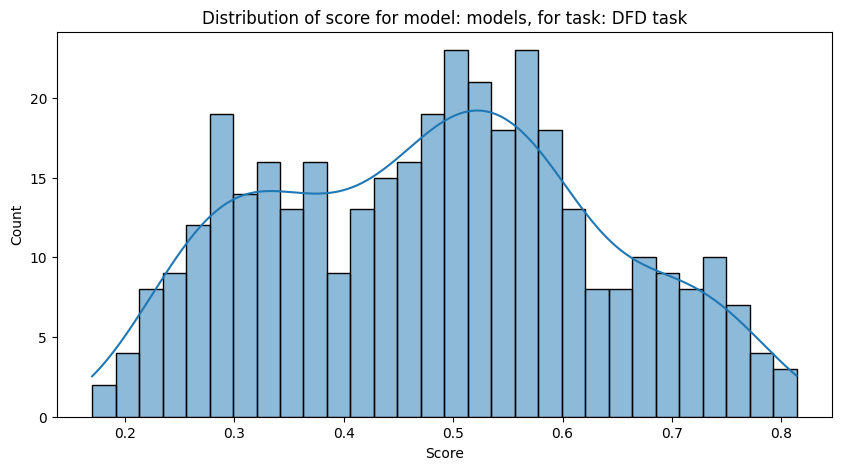

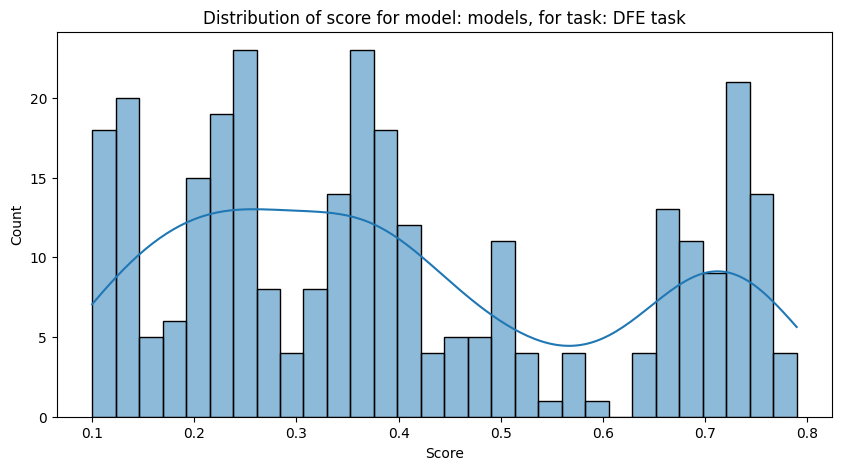

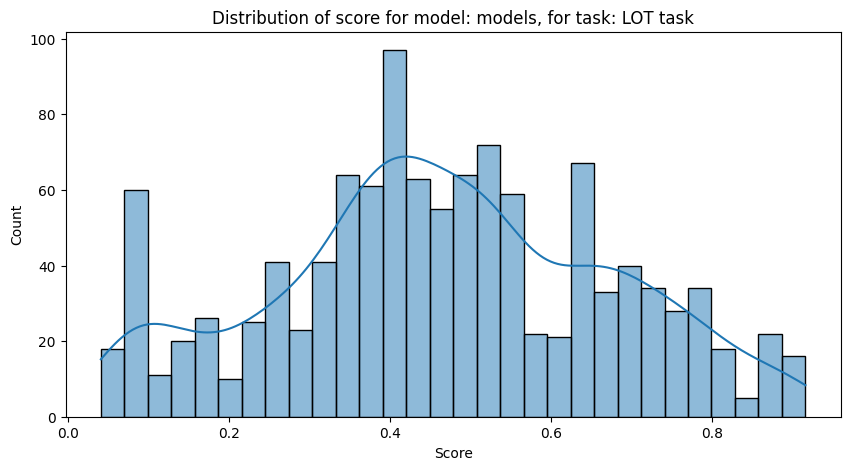

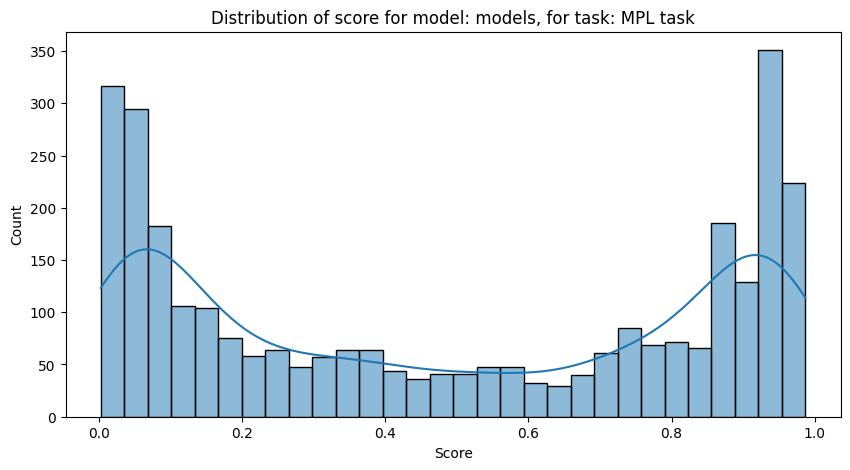

In [12]:
# Visualise distribution (focus on variance) per model of logprobs

#model_names = all_data['model'].unique()
task_names = all_data['experiment'].unique()

#for model_name in model_names:
for task_name in task_names:
    df_plot = all_data[
        #(all_data['model'] == model_name) &
        (all_data['experiment'] == task_name)
    ]
    
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df_plot, x="score", kde=True, bins=30)  
    plt.title(f'Distribution of score for model: models, for task: {task_name}')
    plt.xlabel('Score')
    plt.ylabel('Count')
    plt.show()